# Introduction to `pygraph`

In JAX, powerful function transformations are applicable to pytree data structures -- such as dictionaries, lists, tuples, and other tree-like forms. Leveraging pytree, JAX enables efficient automatic differentiation, vectorization, and parallelization. However, many practical applications, particularly complex physical systems and neural network models, are better suited to graph representations rather than simple tree structures. To address this need, the `brainstate` library introduces the `pygraph` representation, which enhances JAX function transformations for graph data structures.

## What is `pygraph`?

`pygraph` is a specialized data structure within `brainstate` designed to facilitate JAX transformations for graph-based models. Unlike conventional tree structures, graphs can articulate a broader range of node relationships and dependencies, making them ideal for more intricate model architectures. In scenarios where a model's state relies on the interactions among multiple nodes, graph structures offer enhanced flexibility in representation.

The `pygraph` module utilizes `brainstate.graph.Node` as its foundational element, constructing graph structures by defining relationships (edges) between nodes. Each node can hold arbitrary pytree array data or nested `pygraph` substructures, promoting a more adaptable and modular approach to graph construction.

We can think of `brainstate.graph.Node` as a container class, where its attributes denote its leaf nodes. These containers can reference one another, thereby facilitating the creation of complex graph structures.


In [1]:
import jax
import jax.numpy as jnp

import brainstate

In [2]:
class A(brainstate.graph.Node):
    def __init__(self):
        self.w = brainstate.random.rand(2, 3)
        self.b = brainstate.ShortTermState(brainstate.random.rand(3))

In the code above, we define a class `A` that inherits from `brainstate.graph.Node`. Within the class's initialization function, we define two attributes, `w` and `b`, which represent a randomly generated 2x3 matrix and a randomly generated array of length 3, respectively. Both of these data structures are JAX pytree structures.

It is noteworthy that `brainstate.graph.Node` allows us to create cyclic references. For example, 

In [3]:
a = A()
a.self = a

We set the `self` attribute of `a` to `a`, thereby creating a cyclic reference. This type of referencing is not permitted in tree structures, but it is valid in graph structures. Such cyclic references can be used to represent complex model architectures, such as the recurrent connections in recurrent neural networks. Through this flexible referencing method, we can more naturally express the dynamic relationships between nodes in neural networks.

In [4]:
# inspect the "graphdef" of a

brainstate.graph.graphdef(a)

NodeDef(
  type=A,
  index=0,
  attributes=('b', 'self', 'w'),
  subgraphs={
    'self': NodeRef(
      type=A,
      index=0
    )
  },
  static_fields={
    'w': Array([[0.10448933, 0.59558105, 0.7708304 ],
           [0.54522824, 0.79741836, 0.8664371 ]], dtype=float32)
  },
  leaves={
    'b': NodeRef(
      type=ShortTermState,
      index=1
    )
  },
  metadata=(<class '__main__.A'>,),
  index_mapping=None
)

## Overview of `brainstate.graph.Node`

`brainstate.graph.Node` is the foundational class in `pygraph`, defining the structure and behavior of each node within the graph. The **attributes** of each node represent its leaf nodes and can accommodate any JAX array or other transformable data types. The **methods** associated with each node facilitate operations for manipulating, updating, and transforming the data contained within.

In `brainstate`, any neural network module subclass `brainstate.graph.Node`, allowing for the flexible construction of various neural network architecture. This design ensures excellent scalability while fully harnessing the powerful computational capabilities provided by JAX. For instance, we can easily define a simple linear layer module:

In [5]:
class MLP(brainstate.graph.Node):
    def __init__(self):
        self.l1 = brainstate.nn.Linear(2, 3)
        self.l2 = brainstate.nn.Linear(3, 4)
        self.l3 = brainstate.nn.Linear(4, 5)
        self.st = brainstate.ShortTermState(brainstate.random.rand(5))

Nodes can be created and manipulated using the following attributes and methods:

- **Data Storage**: Each `brainstate.graph.Node` can store any JAX arrays or other transformable data types within its *attributes*.

- **Node Connections**: The *attributes* of a `brainstate.graph.Node` can reference other `brainstate.graph.Node` instances, establishing complex dependency graphs -- as illustrated by the three linear layer modules within the `MLP` class above.

- **Attributes and Their Paths**: Every `brainstate.graph.Node` includes a unique path for retrieval and transformation. This path aids in identifying and accessing nodes within complex structures, representing the node's position within the hierarchical nesting of the graph.

For instance, we can view the leaf data points in the `MLP` graph using the following code:

In [6]:
mlp = MLP()

for path, leaf in brainstate.graph.iter_leaf(mlp):
    print(path, leaf.__class__.__name__ if isinstance(leaf, brainstate.State) else leaf)

('l1', '_in_size', 0) 2
('l1', '_out_size', 0) 3
('l1', 'weight') ParamState
('l2', '_in_size', 0) 3
('l2', '_out_size', 0) 4
('l2', 'weight') ParamState
('l3', '_in_size', 0) 4
('l3', '_out_size', 0) 5
('l3', 'weight') ParamState
('st',) ShortTermState



We can also view all nodes in the `MLP` graph using the following code:


In [7]:
for path, node in brainstate.graph.iter_node(mlp):
    print(path, node.__class__.__name__)

('l1',) Linear
('l2',) Linear
('l3',) Linear
() MLP



## Common Functions in `pygraph`

`brainstate` provides numerous utilities for operating on `pygraph`, which can be found in the [`brainstate.graph` module](../apis/graph.rst).

Overall, the commonly used functions in `pygraph` can be categorized into the following types:

- **Graph Structure Operations**: Functions for constructing and retrieving graph structures, including:
    - `brainstate.graph.graphdef`: View the graph structure
    - `brainstate.graph.iter_node`: Iterate through all child nodes in the graph structure
    - `brainstate.graph.iter_leaf`: Traverse all data points in the graph structure
    - `brainstate.graph.nodes`: View all nodes in the graph structure
    - `brainstate.graph.states`: View all `State` instances in the graph structure

- **Graph Structure Transformations**: Functions for transforming and manipulating graph structures, including:
    - `brainstate.graph.treefy_states`: Convert all `State` instances in the graph structure to pytree
    - `brainstate.graph.clone`: Copy the graph structure
    - `brainstate.graph.treefy_split`: Split the graph structure into a `graphdef` and a pytree representation of `State`
    - `brainstate.graph.treefy_merge`: Merge the `graphdef` and pytree representation of `State` into a graph structure
    - `brainstate.graph.flatten`: Flatten the graph structure into collections of `graphdef` and `State`
    - `brainstate.graph.unflatten`: Restore the flattened graph structure to its original form

- **Graph Structure Modifications**: Functions for modifying and updating graph structures, including:
    - `brainstate.graph.pop_states`: Remove `State` instances from the graph structure that meet certain conditions (see the `filter` protocol section below)
    - `brainstate.graph.update_states`: Update `State` instances in the graph structure that meet certain conditions

- **Graph Structure Conversions**: Functions for converting between pygraph and pytree data structures, including:
    - `brainstate.graph.graph_to_tree`: Convert a graph structure to a pytree
    - `brainstate.graph.tree_to_graph`: Convert a pytree to a graph structure

These functions provide developers with a rich set of tools to achieve flexibility and efficiency when constructing and manipulating graph structures.


After introducing the fundamental concepts and commonly used functions of `pygraph`, we will demonstrate how to use the `pygraph` module to construct and manipulate graph structures through a simple example.

In [8]:
# Splitting the graph structure into `graphdef` and `treefy_states`

graphdef, tree_states = brainstate.graph.treefy_split(mlp)

In [9]:
graphdef

NodeDef(
  type=MLP,
  index=0,
  attributes=('l1', 'l2', 'l3', 'st'),
  subgraphs={
    'l1': NodeDef(
      type=Linear,
      index=1,
      attributes=('_in_size', '_name', '_out_size', 'w_mask', 'weight'),
      subgraphs={
        '_in_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 2
          },
          leaves={},
          metadata=PyTreeDef((*,)),
          index_mapping=None
        ),
        '_name': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_out_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 3
          },
          leaves={},
          metadata=PyTreeDef((*,)),
   

In [10]:
tree_states

NestedDict({
  'l1': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.3659619 , -0.31125584,  1.0778427 ],
             [-0.5968006 , -0.5051795 ,  0.16640717]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l2': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.4297514 ,  0.94077504,  1.7989075 , -0.22609374],
             [ 0.06556923,  0.91115445,  1.1170839 , -0.18267009],
             [ 1.8066524 ,  0.7256765 ,  0.63550776,  0.01369484]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l3': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.10035516,  0.04431533, -0.4407376 ,  0.26091304,  0.5030924 ],
             [-0.18698277,  0.7434753 , -0.5017731 ,  0.17899655,  0.9103125 ],
             [ 0.18539658, -0.1383301 , -0.47763184, -0.11584222,  0.0445422 ],
             [-0.42667

In [11]:
# Merging the `graphdef` structure and `treefy_states`

mlp2 = brainstate.graph.treefy_merge(graphdef, tree_states)

mlp2

MLP(
  l1=Linear(
    in_size=(2,),
    out_size=(3,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.3659619 , -0.31125584,  1.0778427 ],
             [-0.5968006 , -0.5051795 ,  0.16640717]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
    )
  ),
  l2=Linear(
    in_size=(3,),
    out_size=(4,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.4297514 ,  0.94077504,  1.7989075 , -0.22609374],
             [ 0.06556923,  0.91115445,  1.1170839 , -0.18267009],
             [ 1.8066524 ,  0.7256765 ,  0.63550776,  0.01369484]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
    )
  ),
  l3=Linear(
    in_size=(4,),
    out_size=(5,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.10035516,  0.04431533, -0.4407376 ,  0.26091304,  0.5030924 ],
             [-0.18698277,  0.7434753 , -0.5017731 ,  0.17899655,  0.9103125 ],
             [ 0.18539658, -0.1383301 , -0.47763184,

In [12]:
# Viewing all `states` in the graph structure

states = brainstate.graph.states(mlp2)

states

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[-0.3659619 , -0.31125584,  1.0778427 ],
           [-0.5968006 , -0.5051795 ,  0.16640717]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[-0.4297514 ,  0.94077504,  1.7989075 , -0.22609374],
           [ 0.06556923,  0.91115445,  1.1170839 , -0.18267009],
           [ 1.8066524 ,  0.7256765 ,  0.63550776,  0.01369484]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[-0.10035516,  0.04431533, -0.4407376 ,  0.26091304,  0.5030924 ],
           [-0.18698277,  0.7434753 , -0.5017731 ,  0.17899655,  0.9103125 ],
           [ 0.18539658, -0.1383301 , -0.47763184, -0.11584222,  0.0445422 ],
           [-0.42667952, -1.1309302 ,  0.42836535,  0.8008316 , -0.88662344]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  ),
  ('st',

It is noteworthy that most graph operation functions for retrieving `State` instances support the inclusion of a series of `filter` functions to select `State` instances that meet certain conditions. For example, to filter out all `ShortTermState` instances, you can use the following code:

In [13]:
short_term_states = brainstate.graph.states(mlp2, brainstate.ShortTermState)

short_term_states

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.9339858 , 0.55950487, 0.22667873, 0.16428697, 0.20077193],      dtype=float32)
  )
})

## `filter` Filter Syntax

In general, a `filter` has the following function form:

```python
def predicate(path: tuple[Key, ...], value: Any) -> bool:
    ...
```

Here, `Key` is a hashable and comparable data type (often a string), `path` is a tuple of `Key` representing the nested structure corresponding to `value`, and `value` is the value at that path. If the value should be included in the `filter`, the function returns `True`; otherwise, it returns `False`.

For example, we can define a `filter` function to select all `ParamState` instances:

In [14]:
def is_param(path, value) -> bool:
    return isinstance(value, brainstate.ParamState)


print(f'{is_param((), brainstate.ParamState(0.)) = }')

is_param((), bst.ParamState(0.)) = True


However, to simplify the creation of `filter` functions, `brainstate` provides a small domain-specific language (DSL). This allows users to pass types, boolean values, ellipses, tuples/lists, etc., which are internally converted into the corresponding predicates, tuples, or lists.

| Literal | Callable Object | Description |
|---------|------------------|-------------|
| `...` or `True` | `Everything()` | Matches all values |
| `None` or `False` | `Nothing()` | Matches no values |
| `type` | `OfType(type)` | Matches instances of type `type`, or values with a `type` attribute of `type` |
| | `PathContains(key)` | Matches values whose associated `path` contains the specified `key` |
| `'{filter}'` <span style="color:gray">str</span> | `WithTag('{filter}')` | Matches values with a string `tag` attribute equal to `'{filter}'`. Used by `RngKey` and `RngCount`. |
| `(*filters)` <span style="color:gray">tuple</span> or `[*filters]` <span style="color:gray">list</span> | `Any(*filters)` | Matches values satisfying any of the internal `filters` |
| | `All(*filters)` | Matches values satisfying all of the internal `filters` |
| | `Not(filter)` | Matches values that do not satisfy the internal `filter` |

For example, we can use the `filter` DSL to define a filter that selects all `ParamState` instances and other remaining `State` instances:

In [15]:
params, others = brainstate.graph.states(mlp, brainstate.ParamState, ...)

params

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[-0.3659619 , -0.31125584,  1.0778427 ],
           [-0.5968006 , -0.5051795 ,  0.16640717]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[-0.4297514 ,  0.94077504,  1.7989075 , -0.22609374],
           [ 0.06556923,  0.91115445,  1.1170839 , -0.18267009],
           [ 1.8066524 ,  0.7256765 ,  0.63550776,  0.01369484]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[-0.10035516,  0.04431533, -0.4407376 ,  0.26091304,  0.5030924 ],
           [-0.18698277,  0.7434753 , -0.5017731 ,  0.17899655,  0.9103125 ],
           [ 0.18539658, -0.1383301 , -0.47763184, -0.11584222,  0.0445422 ],
           [-0.42667952, -1.1309302 ,  0.42836535,  0.8008316 , -0.88662344]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  )
})

In [16]:
others

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.9339858 , 0.55950487, 0.22667873, 0.16428697, 0.20077193],      dtype=float32)
  )
})

## Conversion Between `pygraph` and `pytree`

The `brainstate` library offers a set of functions for converting between `pygraph` and `pytree`, available in the [`brainstate.graph` module](../apis/graph.rst). Here, we highlight two commonly used functions:

- **`brainstate.graph.treefy_split`**: This function separates the graph structure into its `graphdef` and `TreefyState` instances which are all compatiable with pytree. It allows users to convert all `State` instances in the graph to pytree format while retaining additional node information.

- **`brainstate.graph.treefy_merge`**: This function merge the `graphdef` structure and `TreefyState` instances back into a unified graph. It enables the conversion of a pytree back into a graph structure while preserving other node information from the pytree.

These functions provide users with the flexibility to seamlessly convert between graph structures and pytree, enhancing the convenience of utilizing JAX's function transformation capabilities -- especially in complex model architectures.

We can demonstrate the usage of these functions with the following code:

In [17]:
class Linear(brainstate.nn.Module):
    def __init__(self, din: int, dout: int):
        super().__init__()
        self.w = brainstate.ParamState(brainstate.random.rand(din, dout))
        self.b = brainstate.ParamState(jnp.zeros((dout,)))

    def __call__(self, x):
        return x @ self.w.value + self.b.value


class Count(brainstate.State):
    pass


class MLP(brainstate.graph.Node):
    def __init__(self, din, dhidden, dout):
        self.count = Count(jnp.array(0))
        self.linear1 = Linear(din, dhidden)
        self.linear2 = Linear(dhidden, dout)

    def __call__(self, x):
        self.count.value += 1
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x

In the code above, we defined a simple multilayer perceptron model called `MLP`, which consists of two linear layer modules `Linear` and a counter `Count`. We can view the graph structure of this model using the following code:

In [18]:
model = MLP(1, 32, 1)

graphdef, params_, counts_ = brainstate.graph.treefy_split(MLP(din=1, dhidden=32, dout=1), brainstate.ParamState, Count)

params_

NestedDict({
  'linear1': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
      tag=None
    ),
    'w': TreefyState(
      type=ParamState,
      value=Array([[0.67475975, 0.14342582, 0.09279215, 0.7912407 , 0.6412649 ,
              0.35310984, 0.6024835 , 0.7732656 , 0.6344428 , 0.3745495 ,
              0.11568654, 0.39982736, 0.92343414, 0.78210616, 0.6987963 ,
              0.68683803, 0.18834102, 0.3003025 , 0.87177503, 0.37622106,
              0.12652314, 0.9734528 , 0.31582916, 0.89584935, 0.05520368,
              0.6700369 , 0.31894362, 0.16256857, 0.8334037 , 0.8421583 ,
              0.1473298 , 0.92530775]], dtype=float32),
      tag=None
    )
  },
  'linear2': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0.], dtype=float32),
      tag=None
    ),
    'w': TreefyState(
  

In [19]:
counts_

NestedDict({
  'count': TreefyState(
    type=Count,
    value=Array(0, dtype=int32, weak_type=True),
    tag=None
  )
})

## `pygraph` and JAX Transformations

After converting `pygraph` to `pytree`, we can utilize JAX's function transformation capabilities to operate on it. For example, we can use JAX's `jit` function to compile the `MLP` model, use the `grad` function for automatic differentiation, and use the `vmap` function for batching operations, among others. These functions enable users to perform efficient computational operations on complex model structures with greater convenience.

First, we define a simple dataset:

In [20]:
X = jnp.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + brainstate.random.normal(0, 0.1, size=X.shape)


def dataset(batch_size):
    while True:
        idx = brainstate.random.choice(len(X), size=batch_size)
        yield X[idx], Y[idx]

Next, we use the `jax.jit` function to compile the `MLP` model and apply the `jax.grad` function for automatic differentiation:

In [21]:
@jax.jit
def train_step(params, counts, batch):
    x, y = batch

    def loss_fn(params):
        model = brainstate.graph.treefy_merge(graphdef, params, counts)
        y_pred = model(x)
        new_counts = brainstate.graph.treefy_states(model, Count)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss, new_counts

    grad, counts = jax.grad(loss_fn, has_aux=True)(params)
    #                          |-------- sgd ---------|
    params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)

    return params, counts

We will define a test function to compute the loss of the model:

In [22]:
@jax.jit
def test_step(params, counts, batch):
    x, y = batch
    model = brainstate.graph.treefy_merge(graphdef, params, counts)
    y_pred = model(x)
    loss = jnp.mean((y - y_pred) ** 2)
    return {'loss': loss}

Next, let’s begin training the model:

In [23]:
total_steps = 10_000
for step, batch in enumerate(dataset(32)):
    params_, counts_ = train_step(params_, counts_, batch)

    if step % 1000 == 0:
        logs = test_step(params_, counts_, (X, Y))
        print(f"step: {step}, loss: {logs['loss']}")

    if step >= total_steps - 1:
        break

step: 0, loss: 2.275761365890503
step: 1000, loss: 0.06494982540607452
step: 2000, loss: 0.06554042547941208
step: 3000, loss: 0.064922995865345
step: 4000, loss: 0.0650036633014679
step: 5000, loss: 0.06494753062725067
step: 6000, loss: 0.06509506702423096
step: 7000, loss: 0.06508783996105194
step: 8000, loss: 0.06492926180362701
step: 9000, loss: 0.06513587385416031


Finally, we restore the model and check the number of times it has been called:

In [24]:
model = brainstate.graph.treefy_merge(graphdef, params_, counts_)
print('times called:', model.count.value)

times called: 10000


Finally, we can use the trained model to make predictions on the data and view the prediction results:

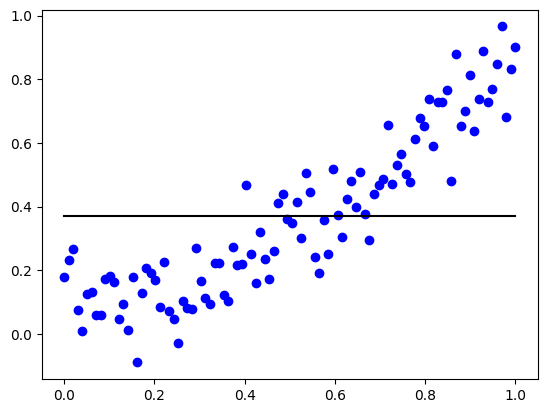

In [25]:
y_pred = model(X)

import matplotlib.pyplot as plt

plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='black')
plt.show()

## Summary

`PyGraph` is a data structure specifically designed in the `brainstate` library to provide JAX function transformation support for complex graph structures. Its core value lies in:

1. **Flexible Expression of Graph Structures**
   - Compared to traditional tree structures (pytree), graph structures can represent more complex node relationships and dependencies.
   - Supports cyclic references, making it suitable for expressing complex model structures.
   - Nodes can contain arbitrary pytree array data or subgraph structures.

2. **Seamless Integration with the JAX Ecosystem**
   - Supports JAX's core functionalities, including automatic differentiation, vectorization, and parallelization.
   - Provides a mechanism for converting between graph structures and pytree.
   - Natively supports JAX function transformations such as `vmap` and `grad`.

We hope that `PyGraph`, with its flexible structural design and powerful functionality, effectively addresses the technical challenges in building complex models.